In [1]:
# Import dependencies
import torch 
from PIL import Image
from torch import nn, save, load
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
# Get data 
train = datasets.MNIST(root="data", download=True, train=True, transform=ToTensor())
dataset = DataLoader(train, 32)
#1,28,28 - classes 0-9

In [3]:
# Image Classifier Neural Network
class ImageClassifier(nn.Module): 
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, (3,3)), 
            nn.ReLU(),
            nn.Conv2d(32, 64, (3,3)), 
            nn.ReLU(),
            nn.Conv2d(64, 64, (3,3)), 
            nn.ReLU(),
            nn.Flatten(), 
            nn.Linear(64*(28-6)*(28-6), 10)  
        )

    def forward(self, x): 
        return self.model(x)

In [4]:
# Instance of the neural network, loss, optimizer 
clf = ImageClassifier().to('cuda')
opt = Adam(clf.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss() 

In [5]:
# Train the model
for epoch in range(10):
    for batch in dataset:
        x, y = batch
        x = x.to('cuda')
        y = y.to('cuda')
        out = clf(x)
        loss = loss_fn(out, y)
        loss.backward()
        opt.step()
        opt.zero_grad()
    print(f"Epoch {epoch} loss: {loss.item()}")
    

Epoch 0 loss: 0.014030827209353447
Epoch 1 loss: 0.0034740359988063574
Epoch 2 loss: 0.0002470856998115778
Epoch 3 loss: 3.378117980901152e-05
Epoch 4 loss: 8.339503983734176e-05
Epoch 5 loss: 4.891603748546913e-05
Epoch 6 loss: 0.00019153226458001882
Epoch 7 loss: 5.516776946024038e-05
Epoch 8 loss: 6.175366434035823e-05
Epoch 9 loss: 0.00017370376735925674


In [7]:
# Plot the model
from torchsummary import summary
summary(clf, (1,28,28))
    

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
              ReLU-2           [-1, 32, 26, 26]               0
            Conv2d-3           [-1, 64, 24, 24]          18,496
              ReLU-4           [-1, 64, 24, 24]               0
            Conv2d-5           [-1, 64, 22, 22]          36,928
              ReLU-6           [-1, 64, 22, 22]               0
           Flatten-7                [-1, 30976]               0
            Linear-8                   [-1, 10]         309,770
Total params: 365,514
Trainable params: 365,514
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.60
Params size (MB): 1.39
Estimated Total Size (MB): 3.00
----------------------------------------------------------------


In [9]:
# Evaluate the model
test = datasets.MNIST(root="data", download=True, train=False, transform=ToTensor())
test_dataset = DataLoader(test, 32)
correct = 0
total = 0
for batch in test_dataset:
    x, y = batch
    x = x.to('cuda')
    y = y.to('cuda')
    out = clf(x)
    _, pred = torch.max(out, dim=1)
    correct += torch.sum(pred == y)
    total += len(y)
    
print(f"Accuracy: {correct/total}")

Accuracy: 0.9872999787330627


In [12]:
# Save the model
save(clf.state_dict(), "model.pth")

In [13]:
# Load the model
clf = ImageClassifier().to('cuda')
clf.load_state_dict(load("model.pth"))
    

<All keys matched successfully>

In [14]:
# Test the model
test = datasets.MNIST(root="data", download=True, train=False, transform=ToTensor())
test_dataset = DataLoader(test, 32)
for batch in test_dataset:
    x, y = batch
    x = x.to('cuda')
    y = y.to('cuda')
    out = clf(x)
    print(out.argmax(1))
    print(y)
    break

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1], device='cuda:0')
tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1], device='cuda:0')


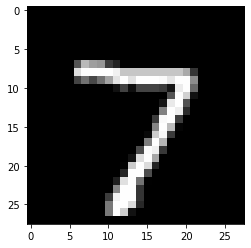

In [15]:
# Plot the image
import matplotlib.pyplot as plt
plt.imshow(x[0].cpu().squeeze(), cmap='gray')
plt.show()

In [16]:
# Predict the plot image
out = clf(x[0].unsqueeze(0).to('cuda'))
print(out.argmax(1))
    

tensor([7], device='cuda:0')
